# Asset Pricing

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import fsolve
from scipy.optimize import broyden1
from scipy.optimize import minimize
from scipy import optimize as opt
import math
import scipy
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
from scipy import stats
import sympy as sy
import pickle

### Problem 1

In [2]:
### Use data cleaning from scott

def convert_to_daily_with_ffill(df):
    '''convert_to_daily_with_ffill

    This method converts a dataframe to have a daily index and forward fills all of the missing days.  Useful for converting (for example) stock market data to quarterly data when the quarterly return is wanted.

    :param df: a pandas.DataFrame to be converted
    :returns: a pandas.DataFrame that has been converted
    '''

    new_idx = pd.date_range('01-01-1950', '07-01-2018')
    df = df.reindex(new_idx)
    df = df.fillna(method="ffill")
    return df

start = datetime.datetime(1950, 1,1)
end = datetime.datetime(2018, 7, 1)
rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
w5000 = convert_to_daily_with_ffill(w5000)
gdef = web.DataReader('GDPDEF', 'fred', start, end)
tb = web.DataReader('TB3MS', 'fred', start, end)

df = pd.DataFrame(columns=['rpce', 'w5000', 'tb', 'gdef'], index = rpce.index)
df['rpce'] = rpce
df['w5000'] = w5000
df['gdef'] = gdef
df['inf'] = df['gdef']/df['gdef'].shift(1)
#df['w5000_d'] = df['w5000']/df['inf']      # Deflated asset price returns
df['R_nom'] = df['w5000'].shift(-1)/df['w5000']
df['R'] = df['R_nom']/df['inf']# Returns to asset prices
df['tb'] = tb/100. + 1    # Convert to percentage and make a gross return
df['rpce_1'] = rpce.shift(-1)
df  = df.dropna(axis=0)   # Drop NaNs
df.head(10)

,rpce,w5000,tb,gdef,inf,R_nom,R,rpce_1
DATE,,,,,,,,
1971-01-01,3156.978,1.00,1.0444,22.391,1.015189,1.120000,1.103243,3185.993
1971-04-01,3185.993,1.12,1.0386,22.685,1.013130,1.008929,0.995853,3211.394
1971-07-01,3211.394,1.13,1.0540,22.916,1.010183,0.991150,0.981159,3264.679
1971-10-01,3264.679,1.12,1.0446,23.107,1.008335,1.053571,1.044863,3307.767
1972-01-01,3307.767,1.18,1.0338,23.458,1.015190,1.067797,1.051819,3370.736
1972-04-01,3370.736,1.26,1.0371,23.604,1.006224,1.007937,1.001702,3422.682
1972-07-01,3422.682,1.27,1.0398,23.830,1.009575,1.023622,1.013914,3503.001
1972-10-01,3503.001,1.30,1.0474,24.134,1.012757,1.069231,1.055762,3566.957
1973-01-01,3566.957,1.39,1.0541,24.412,1.011519,0.920863,0.910377,3565.349


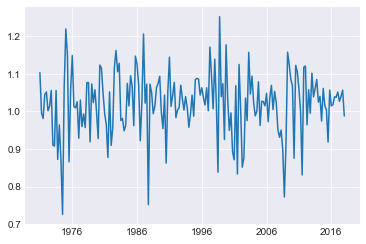

In [3]:
plt.plot(df['R'])

#### 1.1


In [4]:
def sdf(gamma):
    m_tp1 = 0.99*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

In [5]:
def err_1(gamma):
    cov = sdf(gamma).cov(df['R'])
    error = 1 - cov - (sdf(gamma).mean())*(df['R'].mean())
    return error

In [6]:
opt.root(err_1, 1.0)

    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 6
     qtf: array([9.70334924e-14])
       r: array([-0.0075478])
  status: 1
 success: True
       x: array([1.37995685])

#### 1.3

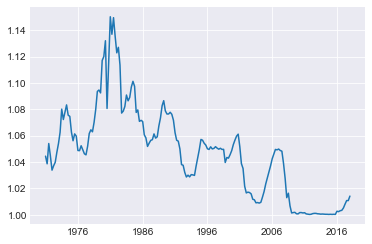

In [7]:
plt.plot(df['tb'])

In [8]:
def err_3(gamma):
    error = df['tb'] - 1/sdf(gamma)
    #errorabs = np.abs(error)
    dist = (error**2).sum()
    return dist

In [9]:
opt.minimize(err_3, 0.8, method = 'Nelder-Mead')

 final_simplex: (array([[2.77023438],
       [2.77015625]]), array([0.33358455, 0.33358455]))
           fun: 0.3335845464433694
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([2.77023438])

#### 1.4

In [10]:
def sdf(gamma, beta):
    m_tp1 = beta*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

In [11]:
def err_4_1(params):
    gamma, beta = params
    cov = sdf(gamma, beta).cov(df['R'])
    error_1 = 1 - cov - (sdf(gamma, beta).mean())*(df['R'].mean())
    
    error_temp = df['tb'] - 1/sdf(gamma, beta)
    #errorabs = np.abs(error_temp)
    error_2 = (error_temp**2).sum()
    
    error = np.zeros(2)
    error[0] = error_1
    error[1] = error_2
    
    return error

In [12]:
def criterion(params, *args):
    gamma, beta = params
    W = args
    error = err_4_1(params)
    crit_val = (error**2).sum()
    return crit_val

In [13]:
W_4 = np.eye(2)
params_init = np.array([5, 0.5])
gmm_args = W_4

In [14]:
opt.minimize(criterion, params_init, args = gmm_args,
            method = 'L-BFGS-B', bounds = ((1e-10, None), (0.9, 1)))

      fun: 0.049870438643526846
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.18170098e-04, -3.08086889e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 14
   status: 0
  success: True
        x: array([1.00000000e-10, 9.55379318e-01])

In [15]:
n = 60
N = 5
gamma_grid = np.linspace(0, 5, n)
beta_grid = np.linspace(0.95, 0.99, N)
gmm_values = np.zeros((n, N))
for i in range(n):
    for j in range(N):
        gmm_values[i, j] = criterion((gamma_grid[i], beta_grid[j]), W_4)

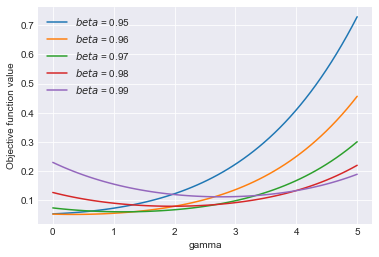

In [16]:
for j in range(N):
    plt.plot(gamma_grid, gmm_values[:, j], label=rf'$beta$ = {beta_grid[j]:.2f}')
plt.xlabel('gamma')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### Problem 2

In [17]:
with open('AAPL', 'rb') as f:
    d = pickle.load(f, encoding='latin1')

ValueError: could not convert string to float

In [38]:
# Import data
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open(file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

ValueError: could not convert string to float

In [45]:
#AAPLraw = pickle.load(open('AAPL.txt', 'rb'))
Craw = pickle.load(open('C.txt.txt', 'rb'))
#GBXraw = pickle.load(open('GBX.txt', 'rb'))
#SPYraw = pickle.load(open('SPY.txt', 'rb'))
#THOraw = pickle.load(open('THO.txt', 'rb'))

ValueError: could not convert string to float

In [40]:
gbxRAW = pd.read_fwf('C.txt', header = None)
gbxRAW.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C.txt'

In [ ]:
import pickle

file_list = ["C", "GBX", "SPY", "THO"]


file_objects = [open(os.path.join(ii), 'rb') for ii in file_list]
data = {ii: pickle.load(jj) for (ii,jj) in zip(file_list, file_objects)}


#data = pickle.load(open("C:/Users/Tim/Documents/OSM/Mybootcampcopy/BootCamp2018/ProbSets/Econ/Week6/AAPL.pickle", "str"))


#pickle.load(open("D:/New/ud120-projects/final_project/final_project_dataset.pkl", "r"))

In [7]:
pickle.load(open("C", "rb")).strip(" ")

ValueError: could not convert string to float

In [9]:
data_1 = pd.read_pickle('test.pkl')

In [14]:
data_1[0]

0      34260
1      34320
2      34380
3      34440
4      34500
5      34560
6      34620
7      34680
8      34740
9      34800
10     34860
11     34920
12     34980
13     35040
14     35100
15     35160
16     35220
17     35280
18     35340
19     35400
20     35460
21     35520
22     35580
23     35640
24     35700
25     35760
26     35820
27     35880
28     35940
29     36000
       ...  
360    55860
361    55920
362    55980
363    56040
364    56100
365    56160
366    56220
367    56280
368    56340
369    56400
370    56460
371    56520
372    56580
373    56640
374    56700
375    56760
376    56820
377    56880
378    56940
379    57000
380    57060
381    57120
382    57180
383    57240
384    57300
385    57360
386    57420
387    57480
388    57540
389    57600
Name: 0, Length: 390, dtype: int64